# XGBoost and GA with GLPK
This notebook contains the implementation of a Genetic Algorithm to carry out feature selection. This hasn't produced a reasonable result however (in fact, it can't find a tree), as it appears to have selected too many features for use with BNP-OCT (35 features currently).

In [1]:
from numpy import loadtxt
import pandas as pd
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# from lsopt.tree import OldOptimalTreeClassifier ## OCT proposed by Bertsimas & Dunn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 

import graphviz

%load_ext autoreload
%autoreload 2

/Users/arman/Documents/Arman/JHU/Assurance/optimaltree-master_2/lsopt/_base.py:639: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if _bin[0][r] is 1:
/Users/arman/Documents/Arman/JHU/Assurance/optimaltree-master_2/lsopt/_base.py:671: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if _bin[0][r] is 0:


In [22]:
data_path_fraud = './data/fraud_data_m_oct_ready.csv'
fraud_data = pd.read_csv(data_path_fraud)
fraud_data

,phy_same,phy_count,period,periodadmt,age,alife,provider_InscClaimAmtReimbursed_mean,provider_DeductibleAmtPaid_mean,provider_NoOfMonths_PartACov_mean,provider_NoOfMonths_PartBCov_mean,...,diag1_OPAnnualDeductibleAmt_mean,diag1_InscClaimAmtReimbursed_std,diag1_DeductibleAmtPaid_std,diag1_NoOfMonths_PartACov_std,diag1_NoOfMonths_PartBCov_std,diag1_IPAnnualReimbursementAmt_std,diag1_IPAnnualDeductibleAmt_std,diag1_OPAnnualReimbursementAmt_std,diag1_OPAnnualDeductibleAmt_std,PotentialFraud
0,2.960000,1.600000,1.440000,1.000000,80.240000,1.000000,4185.600000,213.600000,12.000000,12.000000,...,543.045084,3482.066310,161.353027,0.569945,0.424192,12941.552350,1205.297144,2450.076771,661.506672,Not-Fraud
1,2.439394,1.530303,3.674242,2.424242,71.371212,0.992424,4588.409091,502.166667,11.818182,11.871212,...,676.313985,4017.871066,260.257069,0.726572,0.653285,12620.604410,1226.306633,3369.338617,848.213675,Fraud
2,2.818792,1.604027,1.429530,0.000000,73.516779,0.993289,350.134228,2.080537,11.865772,11.959732,...,694.246881,1536.290845,113.086257,0.667719,0.577420,11016.516940,1111.592405,2972.377916,808.138208,Not-Fraud
3,2.731330,1.599142,1.088412,0.000000,71.783691,0.996567,241.124463,3.175966,11.907296,11.939914,...,630.805985,1234.005090,91.141252,0.657071,0.565930,10021.329570,957.701391,2727.944083,737.419878,Fraud
4,2.736111,1.527778,0.958333,0.222222,70.583333,0.986111,468.194444,45.333333,11.833333,11.833333,...,606.550334,1519.425993,103.302166,0.626542,0.520122,10565.761430,1126.358206,2486.827069,682.279276,Not-Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,2.548387,1.548387,2.806452,0.000000,75.677419,1.000000,127.741935,1.612903,12.000000,12.000000,...,539.926413,1278.578369,105.316369,0.642724,0.506470,10069.067870,1048.496358,2331.087492,676.226785,Not-Fraud
1005,2.500000,1.500000,0.100000,0.000000,78.000000,1.000000,72.000000,0.000000,12.000000,12.000000,...,544.784235,589.615472,61.510304,0.690826,0.473344,10885.075840,1026.840019,2547.341333,723.822292,Not-Fraud
1006,3.000000,2.000000,0.000000,0.000000,74.000000,1.000000,50.000000,0.000000,12.000000,12.000000,...,613.157895,4778.012673,463.684066,0.600751,0.710275,13241.321690,1469.095843,3203.267596,911.406530,Not-Fraud
1007,2.333333,1.333333,2.266667,0.000000,73.933333,1.000000,296.000000,0.000000,12.000000,12.000000,...,566.953462,2506.463260,131.832995,0.726815,0.354062,11262.841610,1196.045563,2691.729344,736.415563,Not-Fraud


In [23]:
X = fraud_data.iloc[:, 0:47].to_numpy()

In [24]:
y = fraud_data["PotentialFraud"].apply(lambda val: 0 if val == "Not-Fraud" else 1).to_numpy()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]    
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))  

Accuracy: 93.56%


In [26]:
thresholds = sort(model.feature_importances_)
max_acc = -1
true_thresh = -1
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions)
    if accuracy >= max_acc and select_X_train.shape[1] < 20:
        max_acc = accuracy
        true_thresh = thresh
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.005, n=41, Accuracy: 93.56%
Thresh=0.009, n=40, Accuracy: 94.06%
Thresh=0.009, n=39, Accuracy: 94.06%
Thresh=0.009, n=38, Accuracy: 94.06%
Thresh=0.010, n=37, Accuracy: 94.06%
Thresh=0.011, n=36, Accuracy: 94.55%
Thresh=0.011, n=35, Accuracy: 94.06%
Thresh=0.011, n=34, Accuracy: 94.06%
Thresh=0.012, n=33, Accuracy: 95.05%
Thresh=0.012, n=32, Accuracy: 94.06%
Thresh=0.012, n=31, Accuracy: 95.54%
Thresh=0.012, n=30, Accuracy: 94.06%
Thresh=0.013, n=29, Accuracy: 95.05%
Thresh=0.013, n=28, Accuracy: 93.56%
Thresh=0.014, n=27, Accuracy: 94.06%
Thresh=0.014, n=26, Accuracy: 94.06%
Thresh=0.014, n=25, Accuracy: 94.06%
Thresh=0.015, n=24, Accuracy: 95.54%
Thresh=0.015, n=23, Accuracy: 94.55%
Thresh=0.016, n=22, Accuracy: 93.56%
Thresh=0.017, n=21, Accuracy: 94.06%
T

In [27]:
print(true_thresh)

0.032147862


In [31]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
select_X_train = selection.transform(X_train)

# OCT parameters
max_depth = 3
min_samples_leaf = 7
alpha = 0.005
time_limit = 10 # minute
mip_gap_tol = 0.05  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
warm_start = False
log_file = None
fp_heur = True
backtrack = "bestb"

# Construct BNP-OCT classifier
selection_model = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': fp_heur,
                                                  'backtrack': backtrack
                                                  }
                                  )

names = []
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] >= true_thresh:
        names.append(fraud_data.iloc[:, [i]].columns[0])
print(len(names))

7


# Explanation of below code
Alright, there's a few functions here, so lets go through them one by one.

### Split
This one is pretty straitforward, its the one that actually splits the data into a training set and a testing set

### acc_score
Returns the accuracy of each model

### plot
For plotting any results of the model, if I need to visualize it

### initialization_of_population
To initialize a random population.

### fitness_score
Returns the best parents for the next run, along with their fitness scores

### selection
Selects the best parents at the end of every run

### crossover
Picks half of the first parents, and half of the second

### mutation
Randomly flip the a feature from True to False (holding true to the principle of the genetic algorithm)

### generations
Executes all the above functions for the specified number of generations

In [37]:
def split(df,label):
    selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
    X_tr = select_X_train
    X_te = X_test
    Y_tr = y_train
    Y_te = y_test
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
import random

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting', 'BNP-OCT']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          XGBClassifier(random_state=0),
          BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': fp_heur,
                                                  'backtrack': backtrack
                                                  }
                                  )]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train = select_X_train
    X_test = select_X_train
    Y_train = y_train
    Y_test = y_train
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))
    
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(select_X_train[:, chromosome],y_train)         
        predictions = logmodel.predict(select_X_train[:, chromosome])
        scores.append(accuracy_score(y_train,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = random.randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

# Explanation of cell below
The below cell essentially generates the accuracy of all the possible model classifiers that can be used (it appears that XGBoost is best, along with AdaBoost)

In [33]:
score = acc_score(select_X_train, y_train)
score

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --mipgap 0.05 --fpump --bestb --write /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpy_gc4vvx.glpk.raw
 --wglp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpbi0rif2c.glpk.glp
 --cpxlp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpops8n487.pyomo.lp
Reading problem data from '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpops8n487.pyomo.lp'...
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpops8n487.pyomo.lp:523330: warning: lower bound of variable 'x11' redefined
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpops8n487.pyomo.lp:523330: warning: upper bound of variable 'x11' redefined
26210 rows, 6622 columns, 438053 non-zeros
133 integer variables, all of which are binary
523463 lines were read
Writing problem data to '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpbi0rif2c.glpk.glp'...
503566 lines were written
GLPK Integer Optimizer 5.0
26210 rows, 6622 columns, 4

,Classifier,Accuracy
0,RandomForest,1.000000
1,DecisionTree,1.000000
2,GradientBoosting,0.998761
3,AdaBoost,0.944238
4,KNeighbors,0.909542
5,BNP-OCT,0.905824
6,RadialSVM,0.895911
7,Logistic,0.887237
8,LinearSVM,0.881041


In [48]:
# Run the GA
logmodel = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': fp_heur,
                                                  'backtrack': backtrack
                                                  }
                                  )
# X_train,X_test, Y_train, Y_test = split(X, y)
chromo_df_bc,score_bc=generations(select_X_train,y_train,size=4,n_feat=select_X_train.shape[1],n_parents=2,mutation_rate=0.00,n_gen=1,
                         X_train = select_X_train,X_test = select_X_train,Y_train = y_train,Y_test = y_train)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --mipgap 0.05 --fpump --bestb --write /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmppv9pk_jn.glpk.raw
 --wglp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpkpjlhkqb.glpk.glp
 --cpxlp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmphexi7vwd.pyomo.lp
Reading problem data from '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmphexi7vwd.pyomo.lp'...
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmphexi7vwd.pyomo.lp:442606: warning: lower bound of variable 'x11' redefined
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmphexi7vwd.pyomo.lp:442606: warning: upper bound of variable 'x11' redefined
22178 rows, 6608 columns, 369439 non-zeros
119 integer variables, all of which are binary
442725 lines were read
Writing problem data to '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpkpjlhkqb.glpk.glp'...
426874 lines were written
GLPK Integer Optimizer 5.0
22178 rows, 6608 columns, 3

In [12]:
# Select the features indicated by the GA
print(chromo_df_bc)
print(names)
# names = []
# select_X_train = []
# for i in range(len(chromo_df_bc[2])):
#     if chromo_df_bc[2][i] == True:
#         names.append(fraud_data.iloc[:, [i]].columns[0])
#         select_X_train.append(X_train[:, i])
# select_X_train = np.asarray(select_X_train).T
# print(len(names))
# print(select_X_train.shape)
# print(X_train.shape)
# print(Y_train.shape)
        

35
(807, 35)
(807, 47)
(807,)


In [13]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
# select_X_train = selection.transform(X_train)

# OCT parameters
max_depth = 5
min_samples_leaf = 1
alpha = 0.01
time_limit = 60  # minute
mip_gap_tol = 0.05  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
fp_heur = True
backtrack = "bestb"

warm_start = False
log_file = None

# Construct BNP-OCT classifier
selection_model = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': "all",
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': True,
                                                  'backtrack': backtrack
                                                  }
                                  )

In [14]:
# Run BNP-OCT
selection_model.fit(select_X_train, Y_train)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 900 --cuts --mipgap 0.05 --fpump --bestb --write /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpzs667ute.glpk.raw
 --wglp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpin0_tvmx.glpk.glp
 --cpxlp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpiifcxh_h.pyomo.lp
Reading problem data from '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpiifcxh_h.pyomo.lp'...
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpiifcxh_h.pyomo.lp:18908370: warning: lower bound of variable 'x35' redefined
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpiifcxh_h.pyomo.lp:18908370: warning: upper bound of variable 'x35' redefined
729050 rows, 27410 columns, 16693737 non-zeros
1457 integer variables, all of which are binary
18909827 lines were read
Writing problem data to '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpin0_tvmx.glpk.glp'...
18205110 lines were written
GLPK Integer Optimizer 5.0
729050 

TypeError: type NoneType doesn't define __round__ method

In [ ]:
# Make prediction
selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
select_X_test = selection.transform(X_train)
y_pred = selection_model.predict(X=select_X_train)
y_pred_prob = selection_model.predict_proba(X=select_X_train)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y_train,
                       y_pred=y_pred))

print(classification_report(y_true=y_train,
                            y_pred=y_pred))

# Plot Optimal Tree
feature_names = names
class_names = ['Not-Fraud', 'Fraud']

dot_data = tree.export_graphviz(selection_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='optimal_tree_fraud', directory='', view=True)

Confusion Matrix :
[[718   0]
 [ 89   0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       718
           1       0.00      0.00      0.00        89

    accuracy                           0.89       807
   macro avg       0.44      0.50      0.47       807
weighted avg       0.79      0.89      0.84       807



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'optimal_tree_fraud.png'

In [ ]:
count = 0
for element in y_pred:
    if element == 1:
        count += 1
print(count)

0


In [ ]:
print(selection_model)

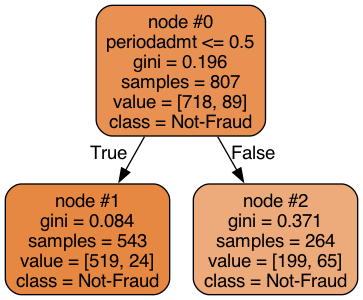

In [ ]:
Image('optimal_tree_fraud.png')

In [ ]:
import pickle
with open('model_pkl', 'wb') as file:
    pickle.dump(selection_model, file)


AttributeError: Can't pickle local object 'solve_oct_MILP_BIN.<locals>.obj_rule'